<a href="https://colab.research.google.com/github/mustafaktaas/Python_StockPricePrediction_MachineLearning/blob/main/StockPricePrediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Prediction using Multivariate LSTM Time Series

In [2]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'Eregli'
symbol = 'EREGL.IS'

import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,2.029706,2.029706,2.029706,2.029706,0.602268,0
2010-01-04,2.047991,2.057134,2.002277,2.029706,0.602268,35918397
2010-01-05,2.038849,2.093706,2.038849,2.075420,0.615832,36745682
2010-01-06,2.075420,2.093706,2.066277,2.084563,0.618545,13854213
2010-01-07,2.075420,2.075420,2.029706,2.047991,0.607693,20201130


In [3]:
pd.options.display.float_format = '{:.3f}'.format

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,2.030,2.030,2.030,2.030,0.602,0
2010-01-04,2.048,2.057,2.002,2.030,0.602,35918397
2010-01-05,2.039,2.094,2.039,2.075,0.616,36745682
2010-01-06,2.075,2.094,2.066,2.085,0.619,13854213
2010-01-07,2.075,2.075,2.030,2.048,0.608,20201130


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3424 entries, 2010-01-01 to 2023-04-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3424 non-null   float64
 1   High       3424 non-null   float64
 2   Low        3424 non-null   float64
 3   Close      3424 non-null   float64
 4   Adj Close  3424 non-null   float64
 5   Volume     3424 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 187.2 KB


In [6]:
df.shape

(3424, 6)

 #### Aldığımız değişkenleri önce bir çizgi grafiği ile çizdiriyoruz.

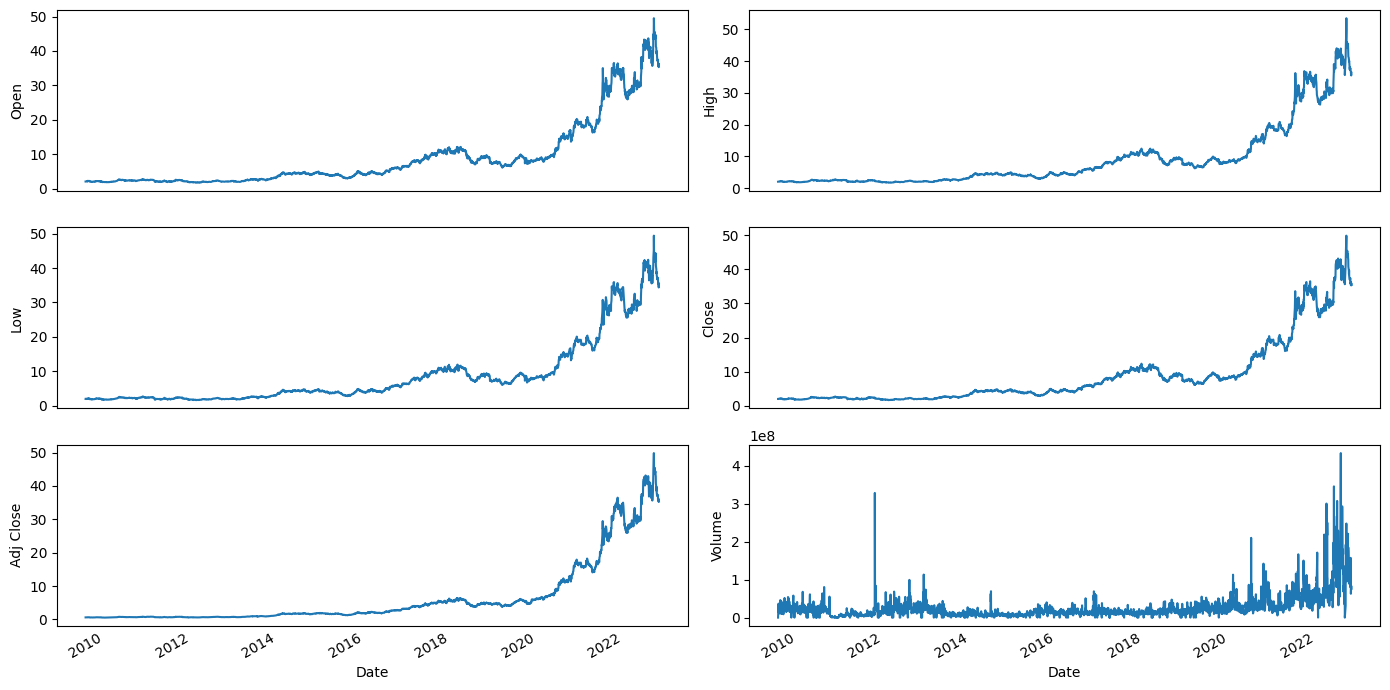

In [7]:
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

#### Bu değişkenleri 0-1 arasında ölçeklendirdiğimizde de aynı grafiğin ortaya çıkmasını bekliyoruz.MinMaxScaler ölçeklendirme işlemi tüm veri değerlerinden en küçük değeri çıkarıp daha sonra bu değerleri en yüksek ile en düşük değerin farkına bölerek uygulanır.x

normalized_df=(df-df.min())/(df.max()-df.min())

normalized_df.head()

df_plot = normalized_df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

#### Burada sinir ağını eğiteceğimiz özelliklerimizi listeliyoruz ve tahmin edeceğimiz fiyatı kapanış fiyatı olarak belirliyoruz.

In [8]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            ,# 'Month' , 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-03-30,36.780,35.880,36.400,35.920,73927685,35.920
2023-03-31,36.220,35.360,35.960,35.400,62835495,35.400
2023-04-03,35.520,34.360,35.280,35.300,83728819,35.300
2023-04-04,35.960,35.120,35.300,35.960,81849531,35.960
2023-04-05,36.380,35.360,36.020,35.420,76033243,35.420


In [9]:
data_filtered.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2023-03-30,36.780,35.880,36.400,35.920,73927685
2023-03-31,36.220,35.360,35.960,35.400,62835495
2023-04-03,35.520,34.360,35.280,35.300,83728819
2023-04-04,35.960,35.120,35.300,35.960,81849531
2023-04-05,36.380,35.360,36.020,35.420,76033243


## Sor

data_filtered = data_filtered.drop("Close",axis = 1)

In [10]:
data_filtered.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2023-03-30,36.780,35.880,36.400,35.920,73927685
2023-03-31,36.220,35.360,35.960,35.400,62835495
2023-04-03,35.520,34.360,35.280,35.300,83728819
2023-04-04,35.960,35.120,35.300,35.960,81849531
2023-04-05,36.380,35.360,36.020,35.420,76033243


#### Burada girdi verilerini numpy formatına dönüştürüp 0-1 arasında MinMaxScaler ile ölçeklendiriyoruz.Bu ölçeklendirdiğimiz veriler eğitildiğinde sonuçlar da ölçeklenmiş şekilde gelecektir bunu geri dönüştürmeyi unutmamalıyız.

In [11]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3424, 5)


In [12]:
np.set_printoptions(precision=3)

np_data = np.around(np_data, 3)

In [13]:
np_data[1]

array([2.057e+00, 2.002e+00, 2.048e+00, 2.030e+00, 3.592e+07])

In [14]:
np_data_scaled[0]

array([0.006, 0.008, 0.007, 0.007, 0.   ])

In [15]:
np_Close_scaled[0]

array([0.007])

#### Çok değişkenli modelimizi üç boyutlu veri yapısına yönelik eğitiyoruz.
#### Birinci : Sequences(Diziler)
#### İkinci : Time Steps(Mini-Batches)
#### Üçüncü : Features(Özellikler)
#### Birincil hedefimiz verileri ilişkili hedef girdi değerleriyle birden çok girdi veri dizisine dilimlemektir. Kayan pencere kullanımı sağlayan bir python kodu yazıyoruz. Bu yaklaşım, her adımda girdi verilerine birden çok veri noktası dizisi ekleyerek bir pencereyi zaman serisi verileri arasında hareket ettirir. Hedef değer (örn. Kapanış Fiyatı) bu sırayı takip eder ve biz onu ayrı bir hedef veri setinde saklarız. Ardından pencereyi bir adım daha ileri iterek bu etkinlikleri tekrarlıyoruz. Bu işlem, her biri hedef kayıtta karşılık gelen bir hedef değere sahip birçok giriş dizisine (mini yığınlar) sahip bir veri seti ile sonuçlanır. Bu süreç hem eğitim hem de test verileri için geçerlidir.
#### Sonuç olarak her biri 5 özellik içeren 2535 train verimiz oluyor.

In [16]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2690, 50, 5) (2690,)
(684, 50, 5) (684,)
0.00617291452381416
0.00617291452381416


#### Sinir ağımızın mimarisi aşağıdaki dört katmandan oluşur:
#### Mini gruplarımızı girdi olarak alan ve tüm diziyi döndüren bir LSTM katmanı
#### Diziyi önceki katmandan alan ancak yalnızca beş değer döndüren başka bir LSTM katmanı
#### Beş nöronlu yoğun katman
#### Öngörülen değeri veren son yoğun katman
#### İlk katmandaki nöronların sayısı, girdi verilerinin bir mini partisinin boyutuna eşit olmalıdır. Veri kümemizdeki her mini parti, 50 adım ve beş özellik içeren bir matristen oluşur. Böylece, tekrarlayan sinir ağımızın giriş katmanı 250 nörondan oluşur. Bu mimariyi akılda tutmak önemlidir çünkü daha sonra yeni bir veri kümesini tahmin etmek istediğimizde verileri aynı şekle getirmemiz gerekir. Aşağıdaki kodu çalıştırmak model mimarisini oluşturur ve modeli derler.

In [17]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 

model.add(LSTM(n_neurons, return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

250 50 5


In [18]:
callbacks = EarlyStopping(monitor = "loss",patience = 8,verbose = 1)

In [19]:
epochs = 50
batch_size = 16
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
169/169 [==============================] - 62s 339ms/step - loss: 8.2626e-05 - val_loss: 8.8721e-04
Epoch 2/50
169/169 [==============================] - 53s 314ms/step - loss: 2.4626e-05 - val_loss: 9.6505e-04
Epoch 3/50
169/169 [==============================] - 54s 320ms/step - loss: 2.5854e-05 - val_loss: 7.0172e-04
Epoch 4/50
169/169 [==============================] - 54s 318ms/step - loss: 2.8229e-05 - val_loss: 8.9643e-04
Epoch 5/50
169/169 [==============================] - 52s 308ms/step - loss: 2.1335e-05 - val_loss: 0.0018
Epoch 6/50
169/169 [==============================] - 52s 308ms/step - loss: 1.7748e-05 - val_loss: 5.2304e-04
Epoch 7/50
169/169 [==============================] - 55s 324ms/step - loss: 1.9079e-05 - val_loss: 5.8672e-04
Epoch 8/50
169/169 [==============================] - 51s 300ms/step - loss: 1.7835e-05 - val_loss: 4.9017e-04
Epoch 9/50
169/169 [==============================] - 51s 301ms/step - loss: 1.2696e-05 - val_loss: 6.0691e-04
Epoch

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

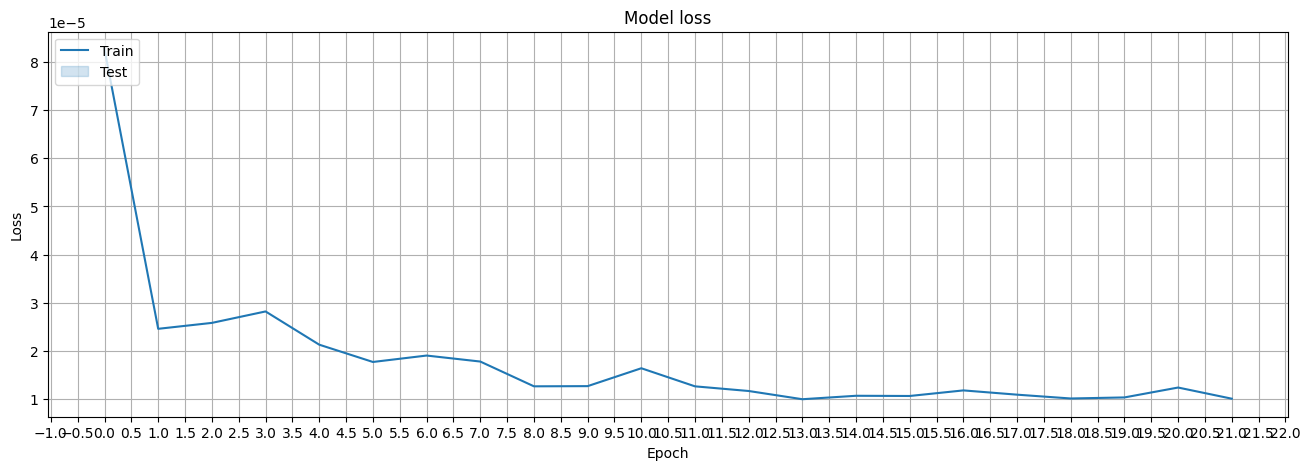

In [20]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [21]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 7s 203ms/step
R2: 0.993
Median Absolute Error (MAE): 0.52
Mean Absolute Percentage Error (MAPE): 2.05 %
Median Absolute Percentage Error (MDAPE): 1.43 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

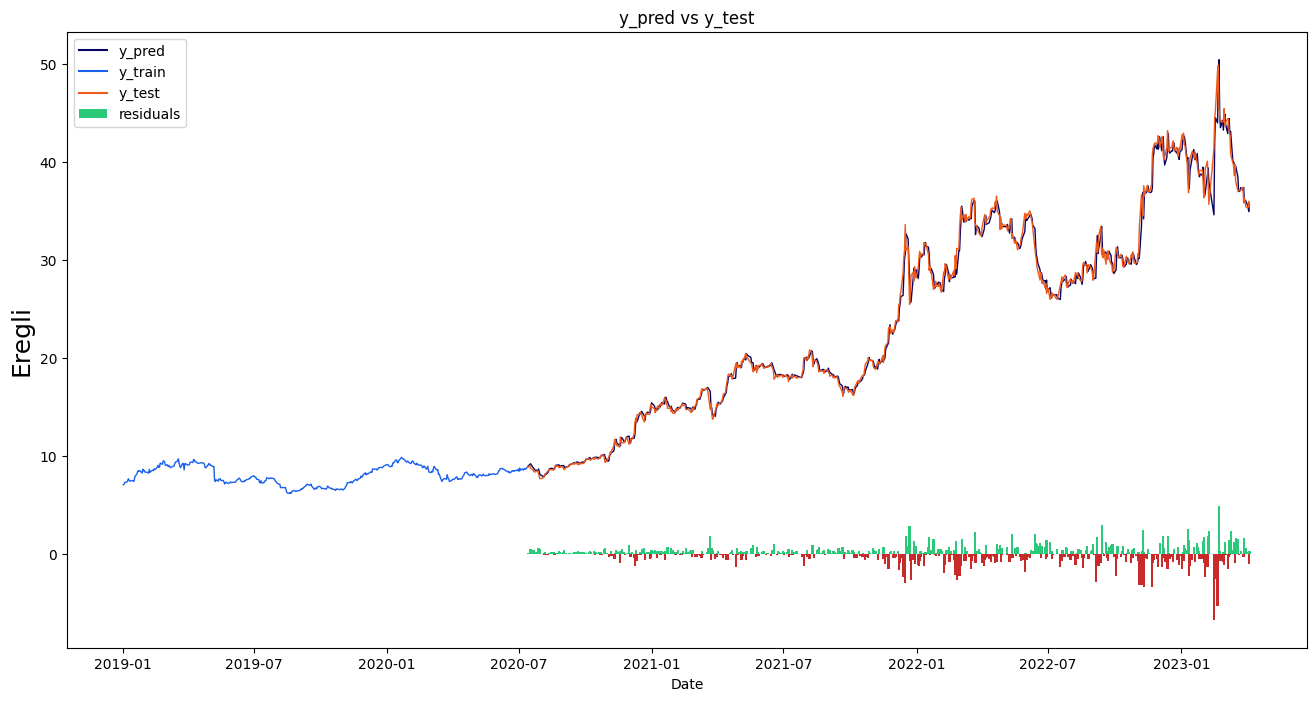

In [22]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [23]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 57ms/step
The close price for Eregli at 2023-04-06 was 35.42
The predicted close price is 35.59000015258789 (+0.48%)


## WindowSize + BatchSize Update

In [24]:
sequence_length = 64

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2676, 64, 5) (2676,)
(684, 64, 5) (684,)
0.009778221130571856
0.009778221130571856


In [ ]:
train_data.shape

(2710, 5)

In [ ]:
model=Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(LSTM(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(LSTM(n_neurons,return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

320 64 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64, 320)           417280    
                                                                 
 lstm_3 (LSTM)               (None, 320)               820480    
                                                                 
 dense_2 (Dense)             (None, 5)                 1605      
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,239,371
Trainable params: 1,239,371
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = EarlyStopping(monitor = "loss",patience = 6,verbose = 1)

In [ ]:
epochs = 50
batch_size = 32
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
83/83 [==============================] - 29s 305ms/step - loss: 1.6753e-04 - val_loss: 0.0010
Epoch 2/50
83/83 [==============================] - 25s 306ms/step - loss: 9.1632e-06 - val_loss: 8.1137e-04
Epoch 3/50
83/83 [==============================] - 26s 307ms/step - loss: 8.6542e-06 - val_loss: 9.2338e-04
Epoch 4/50
83/83 [==============================] - 25s 305ms/step - loss: 8.3755e-06 - val_loss: 5.5754e-04
Epoch 5/50
83/83 [==============================] - 26s 313ms/step - loss: 8.5894e-06 - val_loss: 0.0012
Epoch 6/50
83/83 [==============================] - 26s 316ms/step - loss: 8.4383e-06 - val_loss: 9.6068e-04
Epoch 7/50
83/83 [==============================] - 26s 313ms/step - loss: 6.7071e-06 - val_loss: 0.0011
Epoch 8/50
83/83 [==============================] - 26s 316ms/step - loss: 7.0725e-06 - val_loss: 9.0189e-04
Epoch 9/50
83/83 [==============================] - 26s 315ms/step - loss: 7.7155e-06 - val_loss: 9.3151e-04
Epoch 10/50
83/83 [============

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

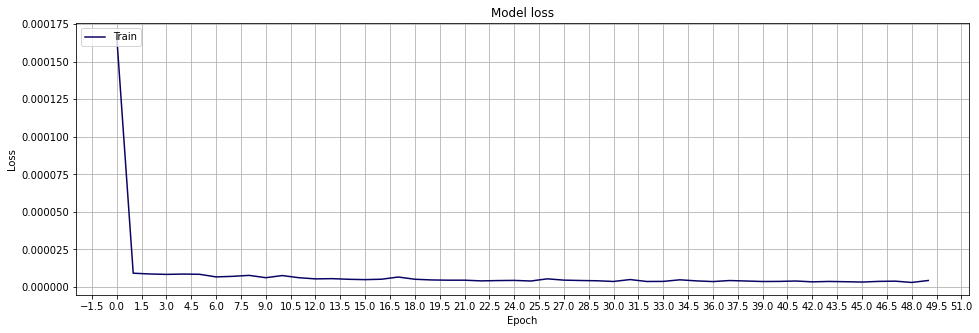

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [ ]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 3s 113ms/step
R2: 0.997
Median Absolute Error (MAE): 1.0
Mean Absolute Percentage Error (MAPE): 2.26 %
Median Absolute Percentage Error (MDAPE): 1.59 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

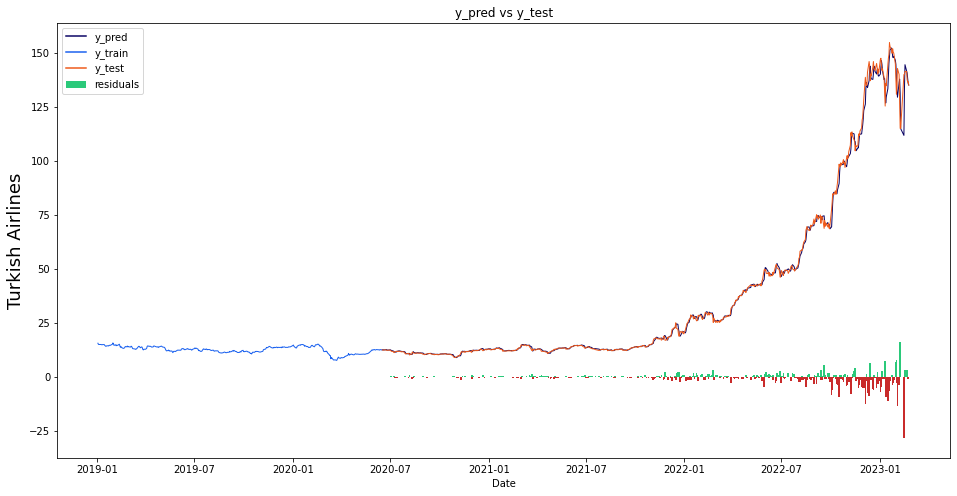

In [ ]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 31ms/step
The close price for Turkish Airlines at 2023-02-26 was 135.0
The predicted close price is 134.07000732421875 (-0.69%)


## Hidden Layer and Neuron Update

In [ ]:
train_data.shape

(2695, 5)

In [ ]:
model=Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(LSTM(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(LSTM(200,return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

320 64 5
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64, 320)           417280    
                                                                 
 lstm_5 (LSTM)               (None, 200)               416800    
                                                                 
 dense_4 (Dense)             (None, 5)                 1005      
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 835,091
Trainable params: 835,091
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = EarlyStopping(monitor = "loss",patience = 6,verbose = 1)

In [ ]:
epochs = 50
batch_size = 32
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
83/83 [==============================] - 30s 321ms/step - loss: 1.9503e-04 - val_loss: 0.0011
Epoch 2/50
83/83 [==============================] - 29s 344ms/step - loss: 9.1213e-06 - val_loss: 4.9937e-04
Epoch 3/50
83/83 [==============================] - 28s 336ms/step - loss: 8.5719e-06 - val_loss: 3.6200e-04
Epoch 4/50
83/83 [==============================] - 28s 340ms/step - loss: 8.4171e-06 - val_loss: 6.8947e-04
Epoch 5/50
83/83 [==============================] - 29s 346ms/step - loss: 7.7399e-06 - val_loss: 6.3658e-04
Epoch 6/50
83/83 [==============================] - 27s 326ms/step - loss: 7.8864e-06 - val_loss: 4.7057e-04
Epoch 7/50
83/83 [==============================] - 28s 332ms/step - loss: 9.3451e-06 - val_loss: 5.5240e-04
Epoch 8/50
83/83 [==============================] - 27s 327ms/step - loss: 7.3347e-06 - val_loss: 7.7700e-04
Epoch 9/50
83/83 [==============================] - 27s 328ms/step - loss: 7.8898e-06 - val_loss: 4.1075e-04
Epoch 10/50
83/83 [====

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

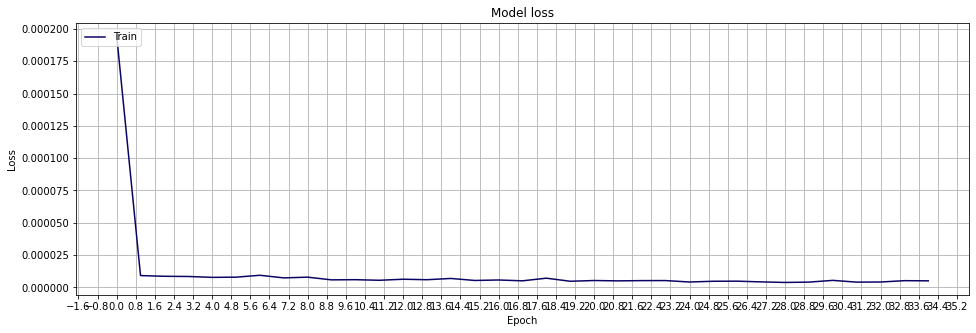

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [ ]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 3s 85ms/step
R2: 0.993
Median Absolute Error (MAE): 1.54
Mean Absolute Percentage Error (MAPE): 3.26 %
Median Absolute Percentage Error (MDAPE): 2.46 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

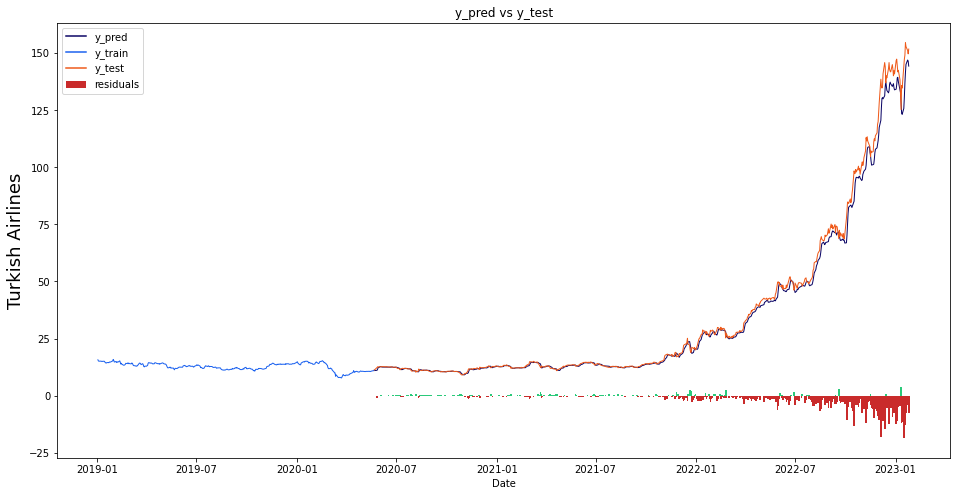

In [ ]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 20ms/step
The close price for Turkish Airlines at 2023-01-26 was 151.8
The predicted close price is 142.72000122070312 (-6.36%)
